In [2]:
%load_ext autoreload
%autoreload 2

import os
from torchvision import models
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score
from PIL import Image
import torch
import pandas as  pd
import scipy.io as sio
import numpy as np
import glob
import natsort
from scipy.spatial.distance import cdist
from sklearn.model_selection import KFold
import copy
import helperFuns as helper

import matplotlib.pyplot as plt

In [3]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Input: (3, 227, 227), Output: (16, 227, 227)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Output: (128, 1, 1)
        )

        self.output_conv = nn.Conv2d(16, 1, kernel_size=1, stride=1, padding=0)  # Output: (1, 1, 1)

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.output_conv(x)  # Reduce to 1 channel per image
        x = x.view(x.size(0), -1)  # Flatten to (B, 1) for BCEWithLogitsLoss
        return x


In [4]:
def train_and_evaluate_model(
    DNN_model_tensor,
    Y_labels_tensor,
    kf,
    SimpleModel,
    device,
    learning_rate,
    batch_size,
    num_epochs,
):

    # Initialize lists to store all fold metrics
    train_losses = []
    val_losses = []
    epoch_losses = []
    all_preds = []
    all_labels = []

    trained_model = []  # Will hold the final model

    for fold, (train_idx, val_idx) in enumerate(kf.split(DNN_model_tensor)):
        print(f"\nFold {fold+1}")

        # Create model and optimizer for each fold
        model = SimpleModel().to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
        criterion = nn.BCEWithLogitsLoss()

        # Split data
        train_data, val_data = DNN_model_tensor[train_idx], DNN_model_tensor[val_idx]
        train_labels, val_labels = Y_labels_tensor[train_idx], Y_labels_tensor[val_idx]

        # Create DataLoaders
        train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(val_data, val_labels), batch_size=batch_size)

        fold_train_losses = []
        fold_val_losses = []

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0

            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                targets = targets.view(-1, 1)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets.float())
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            avg_train_loss = running_loss / len(train_loader.dataset)
            fold_train_losses.append(avg_train_loss)
            print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_train_loss:.4f}")

            # Validation phase
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            fold_preds = []
            fold_labels = []

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    targets = targets.view(-1, 1)

                    outputs = model(inputs)
                    loss = criterion(outputs, targets.float())
                    val_loss += loss.item() * inputs.size(0)

                    preds = (outputs > 0.5).float()
                    fold_preds.extend(preds.cpu().numpy())
                    fold_labels.extend(targets.cpu().numpy())

                    correct += (preds == targets).sum().item()
                    total += targets.size(0)

            avg_val_loss = val_loss / len(val_loader.dataset)
            accuracy = 100 * correct / total
            fold_val_losses.append(avg_val_loss)

            print(f"Validation Loss: {avg_val_loss:.4f} - Accuracy: {accuracy:.2f}%")

        trained_model.append(copy.deepcopy(model))  # Store the trained model for this fold
        
        # Store fold results
        epoch_losses.append(fold_val_losses)
        train_losses.append(fold_train_losses)
        val_losses.append(fold_val_losses)
        all_preds.extend(fold_preds)
        all_labels.extend(fold_labels)

    # Compute final metrics across all folds
    all_preds_np = np.array(all_preds)
    all_labels_np = np.array(all_labels)

    precision = precision_score(all_labels_np, all_preds_np)
    recall = recall_score(all_labels_np, all_preds_np)
    f1 = f1_score(all_labels_np, all_preds_np)

    print(f"\nOverall Metrics:")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Plotting loss curves
    for fold in range(kf.get_n_splits()):
        plt.plot(range(1, num_epochs + 1), train_losses[fold], label=f"Fold {fold+1} - Train Loss", linestyle='--')
        plt.plot(range(1, num_epochs + 1), val_losses[fold], label=f"Fold {fold+1} - Val Loss")

    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': trained_model  # Return the final trained model
    }

In [5]:
def ensemble_predict(models, input_tensor):
    input_tensor = input_tensor.to(device)
    with torch.no_grad():
        outputs = [model(input_tensor).cpu() for model in models]
        outputs = torch.stack(outputs)
        avg_output = torch.mean(outputs, dim=0)
        return torch.sigmoid(avg_output)

In [ ]:
img_size = 10
img_set = 'isetbio' # 'isetbio', 'salicon', 'skeleton', 'texture', 'texture_inplace'
taskName = 'Camel_v2_test_nn' #'Camel_v2_test_nn' 'Camel_Rhino_test_nn' , 'Camel_v2_test_nn', 'Camel_background_matrix'
projectpath = '/mnt/DataDrive3/emeyer/TreeShrewObjectRecognition/'
getDataPath = projectpath + '4_treeShrewBehavior/behaviorData/'
saveDataPath = f'{projectpath}5_behaviorModeling/distData/{taskName}/'

if img_set == 'isetbio':
    img_folder = f'{projectpath}stimulusSets/isettreeshrew/treeshrew_{img_size}/{taskName}_quad/original/merged/'
    img_type = '.png'
elif img_set == 'salicon':
    img_folder = f'{projectpath}stimulusSets/{taskName}/saliconKroner/'
    img_type = '.jpeg'
elif img_set == 'skeleton':
    img_folder = f'{projectpath}stimulusSets/isettreeshrew/treeshrew_{img_size}/{taskName}_quad/skeletonStims/'
    img_type = '.png'
elif img_set == 'texture':
    img_folder = f'{projectpath}stimulusSets/isettreeshrew/treeshrew_{img_size}/{taskName}_quad/texture_metamer_crop/'
    img_type = '.png'
elif img_set == 'texture_inplace':
    img_folder = f'{projectpath}stimulusSets/isettreeshrew/treeshrew_{img_size}/{taskName}_quad/texture_metamer_inplace/'
    img_type = '.png'

In [22]:
train_targ_idx, train_dist_idx, avg_perf = helper.get_train_targdist_data(getDataPath,taskName)

# Load and sort images using natsort
img_files = natsort.natsorted(glob.glob(f'{img_folder}*{img_type}'))

if taskName == 'Camel_Rhino_test_nn':
    img_files = img_files[0:100] + img_files[401:501]
    camel0 = 0
elif (taskName == 'Camel_v2_test_nn') and (img_set == 'texture'):
    camel0 = 0
elif (taskName == 'Camel_v2_test_nn') and (img_set != 'texture'):
    img_files = img_files[0:100] + img_files[302:403]
    camel0 = 0
elif taskName == 'Camel_background_matrix':
    camel0 = 1
all_names = [os.path.splitext(os.path.basename(img_file))[0].split('_') for img_file in img_files]

Y_labels = [name[0] for name in all_names]
unique_labels = np.unique(Y_labels)
print(unique_labels)

# Could run this multiple times with different models if they use different sized inputs
DNN_input_targ, DNN_input_dist = helper.structure_isetbio_data(img_files, Y_labels, unique_labels, input_size = [227,227])

[ 0.  6. 13. 17. 32. 38. 40. 44. 55. 60. 65.]
[ 0.  3. 11. 16. 70. 76. 92.]
[]


UnboundLocalError: cannot access local variable 'DNN_input_targ' where it is not associated with a value

In [ ]:
# Convert avg_perf to a pandas DataFrame
avg_perf_df = pd.DataFrame(avg_perf.flatten())

# Save the DataFrame as a CSV file
avg_perf_df.to_csv(f'{saveDataPath}treeshrew_behavior.csv', index=False, header=False)

In [13]:
# Only keep the images not in the training set for DNN_input_targ
DNN_model_targ = DNN_input_targ[:,:,:,np.isin(range(np.shape(DNN_input_targ)[3]), train_targ_idx-camel0, invert=True)]
DNN_model_dist = DNN_input_dist[:,:,:,np.isin(range(np.shape(DNN_input_dist)[3]), train_dist_idx-camel0, invert=True)]

DNN_heldout_targ = DNN_input_targ[:,:,:,np.isin(range(np.shape(DNN_input_targ)[3]), train_targ_idx-camel0)]
DNN_heldout_dist = DNN_input_dist[:,:,:,np.isin(range(np.shape(DNN_input_dist)[3]), train_dist_idx-camel0)]
print(DNN_heldout_targ.shape, DNN_heldout_dist.shape)

Y_labels_targ = np.repeat(Y_labels[0], np.shape(DNN_model_targ)[3])
Y_labels_dist = np.repeat(Y_labels[-1], np.shape(DNN_model_dist)[3])

Y_heldout_targ = np.repeat(Y_labels[0], np.shape(DNN_heldout_targ)[3])
Y_heldout_dist = np.repeat(Y_labels[-1], np.shape(DNN_heldout_dist)[3])

(227, 227, 3, 11) (227, 227, 3, 7)


In [14]:
# Configuration
num_epochs = 75
k_folds = 5
batch_size = 32
learning_rate = 0.005 #0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Concatenate target and distractor data
DNN_model = np.concatenate((DNN_model_targ, DNN_model_dist), axis=3)

# Concatenate corresponding labels
Y_labels_combined = np.concatenate((Y_labels_targ, Y_labels_dist))

# Convert labels to tensor
Y_labels_tensor = torch.tensor([1 if (label == 'camel') or (label == ' target') else 0 for label in Y_labels_combined])

# Convert DNN_model to tensor
DNN_model_tensor = torch.tensor(DNN_model, dtype=torch.float32).permute(3, 2, 0, 1).to(device)  # Change to (N, C, H, W)

# Compute per-channel mean and std
mean = DNN_model_tensor.mean(dim=(0, 2, 3), keepdim=True)
std = DNN_model_tensor.std(dim=(0, 2, 3), keepdim=True)

# Normalize
DNN_model_tensor = (DNN_model_tensor - mean) / std

# Define K-Fold cross-validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)


Fold 1
Epoch 1/75 - Training Loss: 0.6937
Validation Loss: 0.6795 - Accuracy: 51.35%
Epoch 2/75 - Training Loss: 0.6787
Validation Loss: 0.6647 - Accuracy: 51.35%
Epoch 3/75 - Training Loss: 0.6725
Validation Loss: 0.6530 - Accuracy: 54.05%
Epoch 4/75 - Training Loss: 0.6624
Validation Loss: 0.6392 - Accuracy: 56.76%
Epoch 5/75 - Training Loss: 0.6515
Validation Loss: 0.6243 - Accuracy: 67.57%
Epoch 6/75 - Training Loss: 0.6405
Validation Loss: 0.6082 - Accuracy: 70.27%
Epoch 7/75 - Training Loss: 0.6297
Validation Loss: 0.5933 - Accuracy: 70.27%
Epoch 8/75 - Training Loss: 0.6174
Validation Loss: 0.5778 - Accuracy: 75.68%
Epoch 9/75 - Training Loss: 0.6048
Validation Loss: 0.5638 - Accuracy: 78.38%
Epoch 10/75 - Training Loss: 0.5953
Validation Loss: 0.5515 - Accuracy: 75.68%
Epoch 11/75 - Training Loss: 0.5842
Validation Loss: 0.5411 - Accuracy: 75.68%
Epoch 12/75 - Training Loss: 0.5730
Validation Loss: 0.5310 - Accuracy: 75.68%
Epoch 13/75 - Training Loss: 0.5667
Validation Loss: 

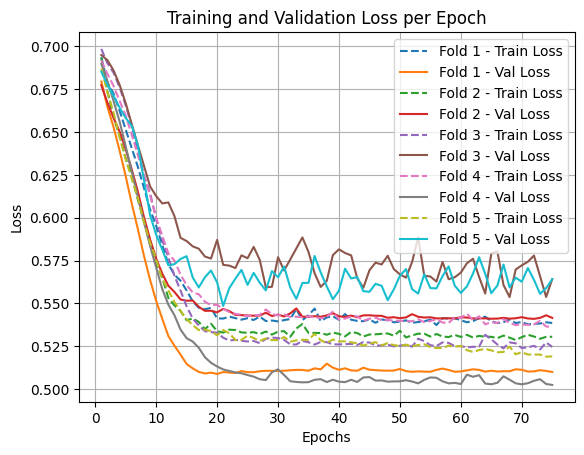

In [15]:
results = train_and_evaluate_model(
    DNN_model_tensor,
    Y_labels_tensor,
    kf,
    SimpleModel,
    device,
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_epochs=num_epochs
)

In [16]:
trained_model = results['model']  # Use the last trained model

DNN_heldout_targ_tensor = torch.tensor(DNN_heldout_targ, dtype=torch.float32).permute(3, 2, 0, 1).to(device)
DNN_heldout_targ_tensor = (DNN_heldout_targ_tensor - mean) / std
outputs_targ = ensemble_predict(trained_model, DNN_heldout_targ_tensor)
preds_targ = (outputs_targ > 0.5).float()

# For distractor images
DNN_heldout_dist_tensor = torch.tensor(DNN_heldout_dist, dtype=torch.float32).permute(3, 2, 0, 1).to(device)
DNN_heldout_dist_tensor = (DNN_heldout_dist_tensor - mean) / std
outputs_dist = ensemble_predict(trained_model, DNN_heldout_dist_tensor)
preds_dist = (outputs_dist > 0.5).float()

# Convert predictions to numpy arrays
preds_targ_np = preds_targ.cpu().numpy()
preds_dist_np = preds_dist.cpu().numpy()

# Convert to 1D arrays for easier handling
preds_targ_np = preds_targ_np.flatten().astype(int)
preds_dist_np = preds_dist_np.flatten().astype(int)

# Convert Y_heldout_targ and Y_heldout_dist to numpy arrays where ([0 if label == 'camel' else 1 for label in Y_labels_combined])
Y_targ = np.array([1 if (label == 'camel') or (label=='target') else 0 for label in Y_heldout_targ])
Y_dist = np.array([1 if (label == 'camel') or (label=='target') else 0 for label in Y_heldout_dist])

# Compute accuracy for heldout target and distractor images
accuracy_targ = np.mean(preds_targ_np == Y_targ)
accuracy_dist = np.mean(preds_dist_np == Y_dist)
accuracy_heldout = np.mean(np.concatenate((preds_targ_np, preds_dist_np)) == np.concatenate((Y_targ, Y_dist)))
print(f"Accuracy on heldout images: {accuracy_heldout:.4f}")

Accuracy on heldout images: 0.8333


In [ ]:
# Extract activations from the model
layers = ['conv_layer.2']

DNN_heldout = np.concatenate((DNN_heldout_targ,DNN_heldout_dist),axis=3)
# activations = helper.get_activations(trained_model, DNN_heldout, layers)

# Collect activations from each model
all_activations = []
avg_activations = {}

for model in trained_model:  # trained_model is your list of models
    model.eval()
    acts = helper.get_activations(model, DNN_heldout, layers, device)
    all_activations.append(acts[layers[0]])

all_activations = np.stack(all_activations)
avg_activations['conv_layer.2'] = np.mean(all_activations, axis=0)
print(avg_activations['conv_layer.2'].shape)

distances = helper.compute_distances(taskName, avg_activations, layers)
print(distances['conv_layer.2'].shape)

# Convert avg_perf to a pandas DataFrame
distances_df = pd.DataFrame(distances['conv_layer.2'].flatten())

# Save the DataFrame as a CSV file
distances_df.to_csv(f'{saveDataPath}{img_set}_distances_combmodel.csv', index=False, header=False)

(18, 1, 16, 1, 1)
(11, 7)


(11, 7)
(11, 7)


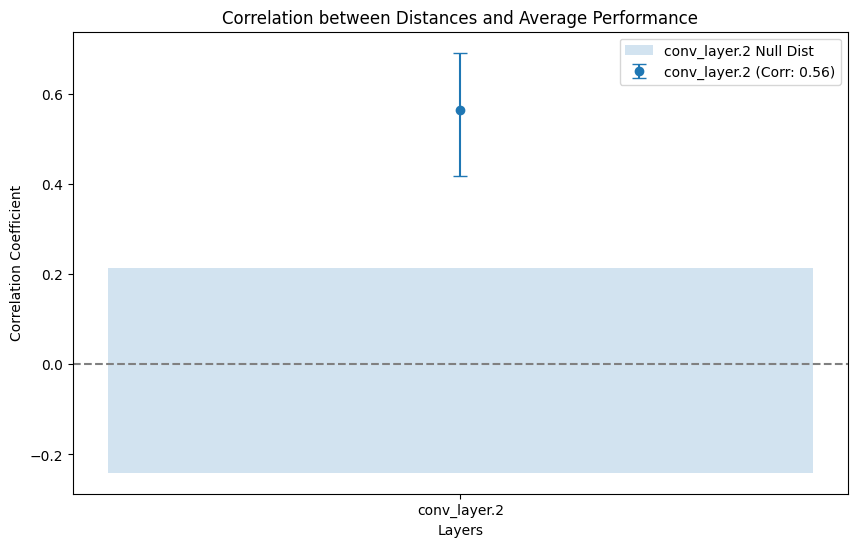

In [ ]:
correlation, ci_lower, ci_upper, shuff_lower, shuff_upper = helper.compute_correlation(avg_perf, distances)
# Save ouptputs to to modeling_results with task and model name
modeling_results = pd.DataFrame({
    'Layer': layers,
    'Correlation': correlation.values(),
    'CI_Lower': ci_lower.values(),
    'CI_Upper': ci_upper.values(),
    'Shuff_Lower': shuff_lower.values(),
    'Shuff_Upper': shuff_upper.values(),
    'Heldout_Accuracy': accuracy_heldout
})
modeling_results.to_csv(f'{saveDataPath}{img_set}_modeling_results.csv', index=False)

# Plot correlation results with error bars
plt.figure(figsize=(10, 6))
for i, layer in enumerate(layers):
    x_pos = i + 1  # Shift x position to start from 1
    plt.errorbar(x_pos, correlation[layer], yerr=[[correlation[layer] - ci_lower[layer]], [ci_upper[layer] - correlation[layer]]],
                 fmt='o', label=f'{layer} (Corr: {correlation[layer]:.2f})', xerr=None, capsize=5)
    plt.fill_betweenx([shuff_lower[layer], shuff_upper[layer]], x_pos - 0.2, x_pos + 0.2, alpha=0.2, label=f'{layer} Null Dist')
    # plt.scatter(x_pos, correlation[layer], label=f'{layer}', color='blue')
plt.axhline(y=0, color='gray', linestyle='--')
# plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Correlation between Distances and Average Performance')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Layers')
plt.xticks(range(1, len(layers) + 1), layers)  # Set x-ticks to layer names
plt.legend()
plt.show()